In [1]:
%%bash
pip install tensorflow
pip install keras
pip install opencv-python
pip install scikit-learn
pip install matplotlib
pip install seaborn
pip install colorama

In [2]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt
# plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2024-02-22 11:52:21.034821: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 11:52:21.192940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 11:52:21.193016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 11:52:21.220686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 11:52:21.287275: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 11:52:21.288397: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
def Video_Play(filepath):
    cap = cv2.VideoCapture(filepath)

    if (cap.isOpened == False):
        print("Error opening video file")
    
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            cv2.imshow('Frame', frame)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

In [4]:
# Classes Directories
NonViolnceVideos_Dir = "real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [5]:
Video_Play(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 16

DATASET_DIR = "real-life-violence-situations-dataset/Real Life Violence Dataset/"
CLASSES_LIST = ["NonViolence", "Violence"]

In [7]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [32]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [33]:
features, labels, video_file_paths = create_dataset()

np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_file_paths)

Extracting Data of Class: NonViolence


[h264 @ 0x6c12ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x6c12ac0] error while decoding MB 98 31
[h264 @ 0x6c12ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x6c12ac0] error while decoding MB 98 31
[h264 @ 0x6c12ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x6c12ac0] error while decoding MB 98 31
[h264 @ 0x6c12ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x6c12ac0] error while decoding MB 98 31


Extracting Data of Class: Violence


In [8]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") , np.load("video_files_paths.npy")

In [9]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [10]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

In [15]:
def create_model():

    model = Sequential()

    ########################################################################################################################

    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################
    early_stopping_callback = EarlyStopping(monitor= 'val_accuracy', patience = 10, restore_best_weights=True)
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5,
                                                             min_lr=0.00005, verbose=1)


    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=["accuracy"])

    model.fit(x=features_train, y=labels_train, epochs = 10, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback, reduce_lr])
    model.summary()

    return model

In [12]:
from tensorflow.keras.models import model_from_json

def save_model(model, model_name):
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")

def load_model(model_name):
    with open(model_name + ".json", "r") as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")

    return loaded_model

In [16]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
# plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

save_model(MoBiLSTM_model, "model")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 16, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

: 

In [10]:
MoBiLSTM_model = load_model("model")

Loaded model from disk


2024-02-22 11:54:31.290526: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.
2024-02-22 11:54:33.697994: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-02-22 11:54:33.698017: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-02-22 11:54:33.698037: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-02-22 11:54:33.698056: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


7/7 [==============================] - 6s 561ms/step
Accuracy Score is :  0.545
Classification Report is : 
               precision    recall  f1-score   support

           0       0.64      0.18      0.28        99
           1       0.53      0.90      0.67       101

    accuracy                           0.55       200
   macro avg       0.59      0.54      0.48       200
weighted avg       0.59      0.55      0.48       200



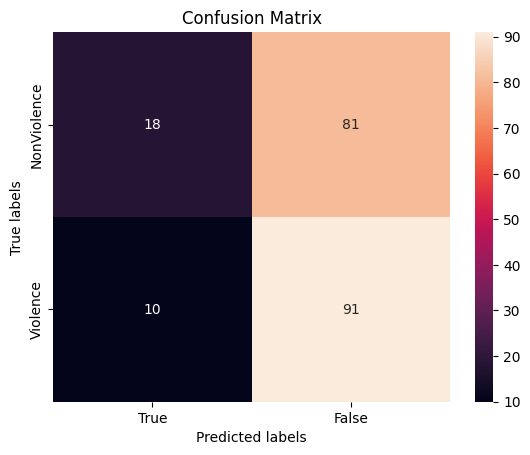

In [14]:
labels_predict = MoBiLSTM_model.predict(features_test)

# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

In [47]:
from colorama import Fore

def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Initialize counters for violence and non-violence
    violence_count = 0
    non_violence_count = 0

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
            print(Fore.RED + predicted_class_name)
            violence_count += 1
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
            print(Fore.GREEN + predicted_class_name)
            non_violence_count += 1

        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)

    if violence_count > 20:
        print(Fore.RED + "[Violence]")
    else:
        print(Fore.GREEN + "[Non Violence]")

    print(Fore.WHITE + str(violence_count))
    print(Fore.WHITE + str(non_violence_count))

    video_reader.release()
    video_writer.release()

In [25]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))

    for counter, random_index in enumerate(random_range, 1):

        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
          break

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()

    video_reader.release()

In [14]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [48]:
input_video_file_path = "real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_35.mp4"
# input_video_file_path = "/content/uccrime_Shooting039_x264.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
# show_pred_frames(output_video_file_path)

# Play the actual video
# Video_Play(input_video_file_path)
















1/1 [==============================] - 0s 34ms/step
NonViolence
1/1 [==============================] - 0s 39ms/step
NonViolence
1/1 [==============================] - 0s 32ms/step
NonViolence
1/1 [==============================] - 0s 30ms/step
NonViolence
1/1 [==============================] - 0s 34ms/step
NonViolence
1/1 [==============================] - 0s 31ms/step
NonViolence
1/1 [==============================] - 0s 31ms/step
NonViolence
1/1 [==============================] - 0s 33ms/step
NonViolence
1/1 [==============================] - 0s 34ms/step
NonViolence
1/1 [==============================] - 0s 33ms/step
NonViolence
1/1 [==============================] - 0s 33ms/step
NonViolence
1/1 [==============================] - 0s 32ms/step
NonViolence
1/1 [==============================] - 0s 33ms/step
NonViolence
1/1 [==============================] - 0s 32ms/step
NonViolence
1/1 [==============================] - 0s 35ms/step
NonViolence
1/1 [====================